# **ASGSA Tools of the Trade** -  Xarray Tutorial  
Author: Brian Horan  


In this tools of the trade, we are going to look at using xarray to open model files.  
Specifically, we will open a .grib2 file and a .nc file.  
Xarray can also be used to open Zarr datasets as well, which are becoming more prevalent in Atmospheric Sciences.  

In [2]:
#Imports
#Import Numpy for fun
import numpy as np
#Import Matplotlib for plotting
import matplotlib.pyplot as plt
#Import Cartopy CRS for plotting and Cartopy Feature for land features
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#Import Xarray to open files
import xarray as xr
#Import Herbie-data to get model files
from herbie.archive import Herbie 
#import metpy calc and metpy units and metpy plots for colormap
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import colortables

We are going to use the Herbie-data API to access operational model data. The Herbie-data API is maintained by Brian Blaylock.  

The case we are going to look at is the December 10, 2021 longtrack KY Tornado. We will plot some surface variables from the HRRR.

In [3]:
#create Herbie object
H = Herbie('2021-12-11 00:00', model = 'hrrr', product = 'sfc', fxx = 2)
#download model file
H.download()

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2021-Dec-11 00:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ aws


Open the dataset with xarray and cfgrib.  
Using cfgrib, it is necessary to select backend arguments which subset the grib2 file into chunks which can be accessed. These look like
 - Type of Level (This includes things like heightAboveGround, Surface, entireAtmosphere, etc.)
 - Level (10, 2, 80)
 - stepType (Instant, Accum, max) - not always necessary 
 
To see which backend arguments are available, I run:  
<code>backend_kwargs = {'filter_by_keys':{}}</code>
which will just show an error message with a list of backend keys.

You can check the NCEI Grib reference linked <a href=https://www.nco.ncep.noaa.gov/pmb/products/hrrr/hrrr.t00z.wrfprsf02.grib2.shtml>here</a> to find variables.  
This will likely clue you in on where to look.
 
Which arguments are required will depend on what data is being accessed. There are a few examples below.  
Here I will open the dataset for surface, 2m, 10m, mean sea level pressure, and radar


In [4]:
file_name = 'C://Users//Brian//data//hrrr//20211211/hrrr.t00z.wrfsfcf02.grib2'
ds = xr.open_dataset(file_name, engine = 'cfgrib', backend_kwargs = {'filter_by_keys':{'typeOfLevel':'meanSea'}})
ds1 = xr.open_dataset(file_name, engine = 'cfgrib', backend_kwargs = {'filter_by_keys':{'typeOfLevel':'heightAboveGround', 'level':2}})
ds2 = xr.open_dataset(file_name, engine = 'cfgrib', backend_kwargs = {'filter_by_keys':{'typeOfLevel':'atmosphere'}})
ds3 = xr.open_dataset(file_name, engine = 'cfgrib', backend_kwargs = {'filter_by_keys':{'typeOfLevel':'surface','stepType':'instant'}})
ds4 = xr.open_dataset(file_name, engine = 'cfgrib', backend_kwargs = {'filter_by_keys':{'typeOfLevel':'heightAboveGround', 'level':10}})
ds1

<xarray.Dataset>
Dimensions:            (y: 1059, x: 1799)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  int32 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    paramId_0          (y, x) float32 ...
    t2m                (y, x) float32 ...
    pt                 (y, x) float32 ...
    sh2                (y, x) float32 ...
    d2m                (y, x) float32 ...
    r2                 (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2022-10-03T15:04:15 GRIB to CDM+CF via cfgrib-0....

Next, We are going to select our variables, as well as set the longitude and latitude variables for plotting. We will do some calculations as well so we can haave some cool looking plots about this date!

In [5]:
#We're gonna create a 4 panel plot of the data soon, so let's grab our variables. We're gonna need to do some calculations as well, so we'll use metpy calc and metpy units to do some calculations
gridlat = ds['latitude'][:]
gridlon = ds['longitude'][:]
mslp = ds['mslma'].values * 0.01
t2m = ds1['t2m'].values - 273
d2m = ds1['d2m'].values - 273
reflectivity = ds2['refc'].values
cape = ds3['cape'].values
u10 = ds4['u10'].values
v10 = ds4['v10'].values

To make plotting a little easier, I will create a method to fill the axis projection for us. This is a method I wrote myself a long time ago.

In [6]:
def set_background(ax):
    ax.set_extent([255, 280, 40, 24])
    ax.coastlines('10m', edgecolor = 'black')
    ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor = 'beige')
    ax.add_feature(cfeature.BORDERS.with_scale('10m'))
    ax.add_feature(cfeature.LAKES.with_scale('10m'), edgecolor = 'black')
    ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor = 'black')
    ax.add_feature(cfeature.OCEAN.with_scale('10m'), edgecolor = 'black')
    #ax.add_feature(mpp.USCOUNTIES.with_scale('5m'))
    return ax

Next, we're going to make a 4 panel plot to visualize the data we just extracted!

C:\Users\Brian\.conda\envs\research\lib\site-packages\cartopy\mpl\geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


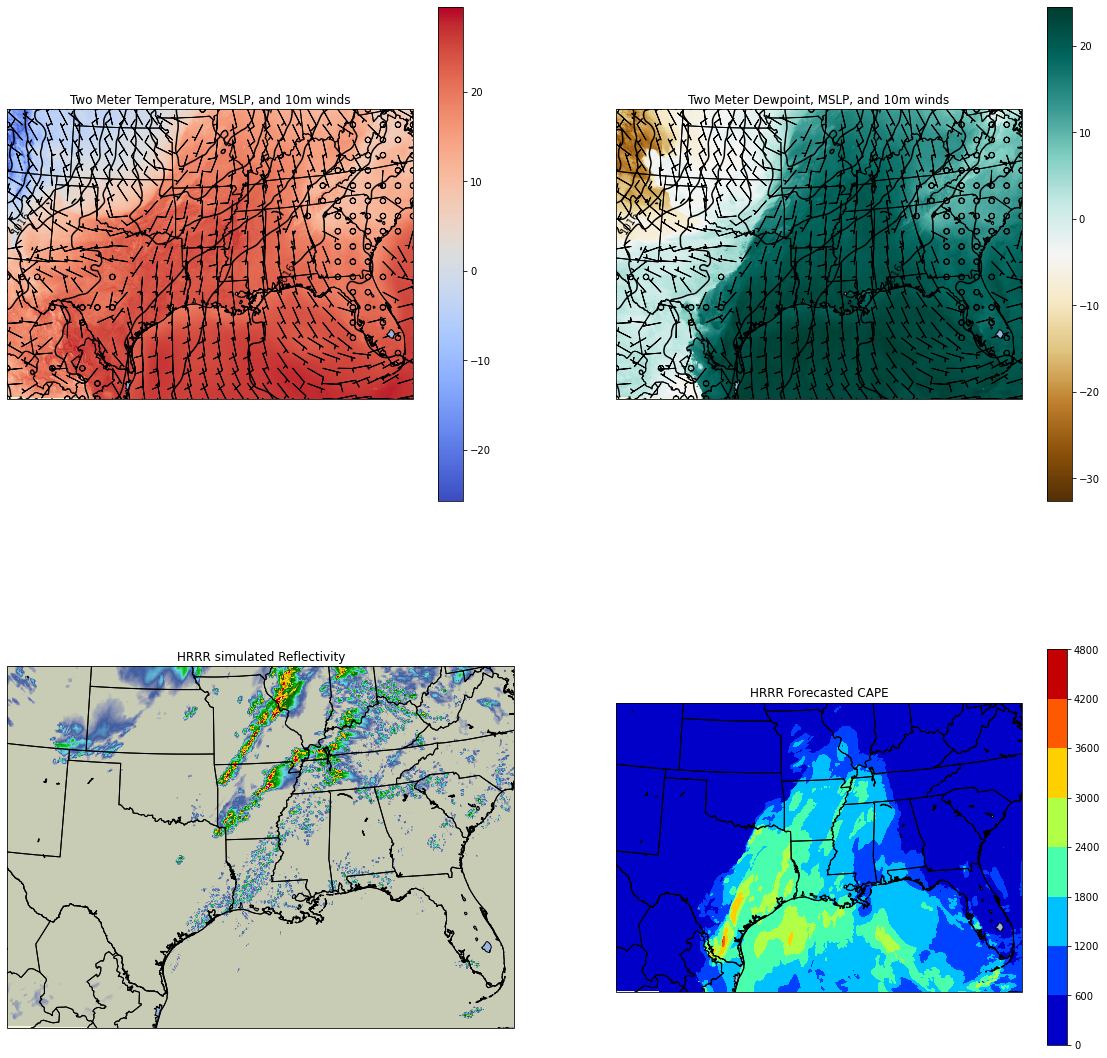

In [7]:
fig = plt.figure(figsize = (20,20))

proj= ccrs.LambertConformal()

ax1 = plt.subplot(2,2,1, projection = proj)
ax2 = plt.subplot(2,2,2, projection = proj)
ax3 = plt.subplot(2,2,3, projection = proj)
ax4 = plt.subplot(2,2,4, projection = proj)

ax1 = set_background(ax1)
ax2 = set_background(ax2)
ax3 = set_background(ax3)
ax4 = set_background(ax4)

plt.rcParams['pcolor.shading']

#Fill in the first plot with 2m temperature, MSLP, and winds
pc1 = ax1.pcolormesh(gridlon, gridlat, t2m, cmap = 'coolwarm', transform=ccrs.PlateCarree())
cs1 = ax1.contour(gridlon, gridlat, mslp, colors = 'black', levels = np.arange(980, 1036, 4), transform = ccrs.PlateCarree())
b1 = ax1.barbs(np.array(ds['longitude']), np.array(ds['latitude']), u10, v10, length = 6, regrid_shape = 20, transform = ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(980,1036,4))
fig.colorbar(pc1, ax = ax1, shrink = 0.8)
ax1.set_title('Two Meter Temperature, MSLP, and 10m winds')

#Fill in the Second plot with 2m dewpoint, MSLP, and winds
pc2 = ax2.pcolormesh(gridlon, gridlat, d2m, cmap = 'BrBG', transform = ccrs.PlateCarree())
cs2 = ax2.contour(gridlon, gridlat, mslp, colors = 'black', levels = np.arange(980, 1036, 4), transform = ccrs.PlateCarree())
b2 = ax2.barbs(np.array(ds['longitude']), np.array(ds['latitude']), u10, v10, length = 6, regrid_shape = 20, transform = ccrs.PlateCarree())
plt.clabel(cs2,levels=np.arange(980,1036,4))
fig.colorbar(pc2, ax = ax2, shrink = 0.8)
ax2.set_title('Two Meter Dewpoint, MSLP, and 10m winds')

#Fill in the 3rd plot with HRRR reflectivity
ctable = ('NWSStormClearReflectivity', -20, 0.5)
norm, cmap = colortables.get_with_steps(*ctable)
refc = ax3.pcolormesh(gridlon, gridlat, reflectivity, norm = norm, cmap = cmap, transform = ccrs.PlateCarree())
ax3.set_title('HRRR simulated Reflectivity')

#Fill in the 4th plot with CAPE
pc4 = ax4.contourf(gridlon, gridlat, cape, cmap = 'jet', transform =ccrs.PlateCarree())
fig.colorbar(pc4, ax=ax4, shrink = 0.8)
ax4.set_title('HRRR Forecasted CAPE')
plt.show()